In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='2-lGYZzFg_1NYpm3Hc1FxjM8D0lxLUMvSScYXuek-ouj',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

bucket = 'agesturebasedtoolforsterilebrowsi-donotdelete-pr-bnlnbcqb2k7omr'
object_key = 'dataset.zip'

streaming_body_3 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [2]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_3.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

In [3]:
ls

dataset/


In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Flatten, Dropout
from tensorflow.keras.layers import Convolution2D,MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen=ImageDataGenerator(rescale=1./255)

In [9]:
#performing data agumentation to train data
x_train = train_datagen.flow_from_directory(r'dataset/train',
                                            target_size=(64, 64),
                                            batch_size=3,
                                            color_mode='grayscale',
                                            class_mode='categorical')
#performing data agumentation to test data
x_test = test_datagen.flow_from_directory(r'dataset/test',
                                          target_size=(64, 64),
                                          batch_size=3,
                                          color_mode='grayscale',
                                          class_mode='categorical') 

Found 594 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [10]:
# Initializing the CNN
model = Sequential()

# First convolution layer and pooling
model.add(Convolution2D(32, (3, 3), input_shape=(64, 64, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Second convolution layer and pooling
model.add(Convolution2D(32, (3, 3), activation='relu'))
# input_shape is going to be the pooled feature maps from the previous convolution layer
model.add(MaxPooling2D(pool_size=(2,2)))

# Flattening the layers i.e. input layer
model.add(Flatten())

# Adding a fully connected layer, i.e. Hidden Layer
model.add(Dense(units=512 , activation='relu'))

# softmax for categorical analysis, Output Layer
model.add(Dense(units=6, activation='softmax')) 

In [11]:
model.summary()#summary of our model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 512)               3

In [12]:
# Compiling the CNN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) 

In [13]:
# Model Train
H = model.fit_generator(x_train,
                    steps_per_epoch = 198 , 
                    epochs = 25, 
                    validation_data = x_test,
                    validation_steps = 10 )

/tmp/wsuser/ipykernel_209/3754161595.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(x_train,


Epoch 1/25
198/198 [==============================] - 13s 60ms/step - loss: 1.3366 - accuracy: 0.4781 - val_loss: 0.4804 - val_accuracy: 0.8000
Epoch 2/25
198/198 [==============================] - 11s 57ms/step - loss: 0.5714 - accuracy: 0.7727 - val_loss: 0.3970 - val_accuracy: 0.8667
Epoch 3/25
198/198 [==============================] - 12s 61ms/step - loss: 0.3879 - accuracy: 0.8502 - val_loss: 0.6077 - val_accuracy: 0.8000
Epoch 4/25
198/198 [==============================] - 11s 57ms/step - loss: 0.2720 - accuracy: 0.8788 - val_loss: 0.3809 - val_accuracy: 0.8667
Epoch 5/25
198/198 [==============================] - 11s 58ms/step - loss: 0.2099 - accuracy: 0.9226 - val_loss: 0.3388 - val_accuracy: 0.9333
Epoch 6/25
198/198 [==============================] - 12s 61ms/step - loss: 0.1629 - accuracy: 0.9394 - val_loss: 0.3647 - val_accuracy: 0.8667
Epoch 7/25
198/198 [==============================] - 12s 59ms/step - loss: 0.1552 - accuracy: 0.9529 - val_loss: 0.4759 - val_accuracy:

In [14]:
# Save the model
model.save('gesture.h5')

In [15]:
model_json = model.to_json()
with open("model-bw.json", "w") as json_file:
    json_file.write(model_json)

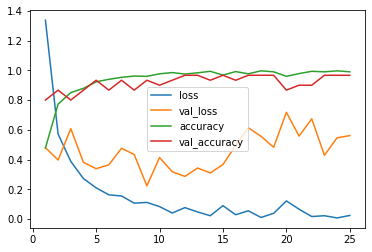

In [16]:
import matplotlib.pyplot as plt

plt.plot(np.arange(1, 25+1), H.history['loss'], label='loss')
plt.plot(np.arange(1, 25+1), H.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig('loss.png')

plt.plot(np.arange(1, 25+1), H.history['accuracy'], label='accuracy')
plt.plot(np.arange(1, 25+1), H.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.savefig('accuracy.png')

# Testing

In [54]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
model_test = load_model("gesture.h5") 

#loading the model for testing
path = "img.png"

In [47]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='2-lGYZzFg_1NYpm3Hc1FxjM8D0lxLUMvSScYXuek-ouj',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.eu.cloud-object-storage.appdomain.cloud')

bucket = 'agesturebasedtoolforsterilebrowsi-donotdelete-pr-bnlnbcqb2k7omr'
object_key = 'img.zip'

streaming_body_4 = cos_client.get_object(Bucket=bucket, Key=object_key)['Body']

# Your data file was loaded into a botocore.response.StreamingBody object.
# Please read the documentation of ibm_boto3 and pandas to learn more about the possibilities to load the data.
# ibm_boto3 documentation: https://ibm.github.io/ibm-cos-sdk-python/
# pandas documentation: http://pandas.pydata.org/


In [48]:
from io import BytesIO
import zipfile
unzip=zipfile.ZipFile(BytesIO(streaming_body_4.read()),'r')
file_paths=unzip.namelist()
for path in file_paths:
    unzip.extract(path)

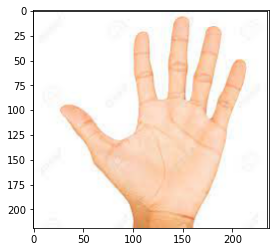

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
imgs = mpimg.imread(path)
imgplot = plt.imshow(imgs)
plt.show()

In [50]:
ls

accuracy.png  dataset/  gesture.h5  img.png  loss.png  model-bw.json


In [51]:
#loading of the image
img = image.load_img(path,
                     color_mode='grayscale',
                     target_size= (64,64))
x = image.img_to_array(img)

#image to array
x.shape

(64, 64, 1)

In [52]:
x = np.expand_dims(x,axis = 0)

x.shape

(1, 64, 64, 1)

In [64]:
pred = np.argmax(model.predict(x), axis=-1)

#predicting the classes

index=['0','1','2','3','4','5']


In [65]:
pred

array([5])

In [66]:

result=str(index[pred[0]])

result

'5'

In [67]:
p = []

for i in range(0,6):
    for j in range(0,5):
        path = "dataset/test/"+str(i)+"/"+str(j)+".jpg"
        img = image.load_img(path,color_mode = "grayscale",target_size= (64,64))
        x = image.img_to_array(img)
        x = np.expand_dims(x,axis = 0)
        pred = np.argmax(model.predict(x), axis=-1)
        p.append(pred)

print(p)

[array([0]), array([0]), array([0]), array([0]), array([0]), array([1]), array([1]), array([1]), array([1]), array([1]), array([2]), array([2]), array([1]), array([2]), array([2]), array([3]), array([3]), array([3]), array([3]), array([3]), array([4]), array([4]), array([4]), array([4]), array([4]), array([5]), array([5]), array([5]), array([5]), array([5])]


In [68]:
result = []
index=['0','1','2','3','4','5']
for i in p:
    result.append(index[i[0]])
    
print(result)

['0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '2', '2', '1', '2', '2', '3', '3', '3', '3', '3', '4', '4', '4', '4', '4', '5', '5', '5', '5', '5']


###  Team Members

          Nalinkumar S
          Ranjith S
          Amuthayazhini K
          Mithrha R

